# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import cv2
import tensorflow as tf
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import AdamW, Adam, RMSprop
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.applications import MobileNet
from keras.applications import DenseNet169
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import time
from keras.callbacks import Callback
from concurrent.futures import ProcessPoolExecutor

2024-03-13 15:16:29.971455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 15:16:29.971553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 15:16:30.135002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__

'2.15.0'

In [3]:
!nvidia-smi

Wed Mar 13 09:42:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Resizing the images to (224, 224) as required by DenseNet

## Images aren't resized

(256, 256, 3)


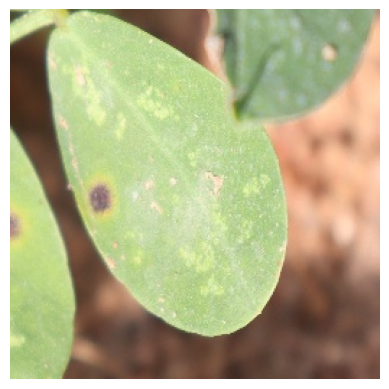

In [2]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/groundnout-augmented-dataset/groundnut_dataset/Early Leaf Spot/152_1.jpg'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

## Resizing the images

In [ ]:
inp_dir = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data'

target_size = (224, 224)

print(os.listdir(inp_dir))

for folder in os.listdir(inp_dir):


  folder_path = os.path.join(inp_dir, folder)
  if os.path.isdir(folder_path):

    print(f'Processing images in the folder: {folder}')
    for filename in os.listdir(folder_path):

      if filename.endswith(('.jpg', '.jpeg', '.png')):



        #load the img
        img_path = os.path.join(folder_path, filename)
        img = mpimg.imread(img_path)

        #resizing
        resized_img = cv2.resize(img, target_size)

        #overwriting the input images with the resized images
        mpimg.imsave(img_path, resized_img)


print('Done with Resizing')

## Checking whether or not the image have been resized

(224, 224, 3)


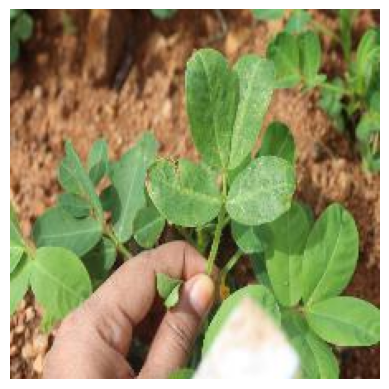

In [5]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data/early_leaf_spot/IMG_0325.JPG'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

# Converting the images to array 

In [3]:
def convert_img_to_array(image_dir):
  try:
    img = cv2.imread(image_dir)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])

  except Exception as e:
    print(f'Error: {e}')
    return None

# Reading the images and converting them into an array

In [4]:
def process_directory(args):
    directory, temp = args
    images = []
    labels = []
    for files in os.listdir(directory):
        img_path = os.path.join(directory, files)
        images.append(convert_img_to_array(img_path))
        labels.append(binary_labels[temp])
    return images, labels

# Reading the images one by one and converting them into an array

In [5]:
#dir = '/content/drive/MyDrive/Plant-Disease-v1/Dataset'
dir = '/kaggle/input/groundnout-augmented-dataset/groundnut_dataset'
image_list, label_list = [], []
#all_labels = os.listdir('/content/drive/MyDrive/Plant-Disease-v1/Dataset')
all_labels = os.listdir('/kaggle/input/groundnout-augmented-dataset/groundnut_dataset')
# binary_labels = [0, 1]
#temp = -1

binary_labels = list(range(6))

#Reading and Converting the image into to numpy array
for temp, directory in enumerate(all_labels[:6]):
    plant_img_list = os.listdir(f'{dir}/{directory}')
    for files in plant_img_list:
        img_path = f'{dir}/{directory}/{files}'
        image_list.append(convert_img_to_array(img_path))
        label_list.append(binary_labels[temp])


In [7]:
print(all_labels)
# print(image_list[0].shape)

['Healthy Leaf', 'Early Leaf Spot', 'Rust', 'Late Leaf Spot', 'Nutritional Deficiency', 'Early Rust']


## Checking the frequecny of images in each class

In [5]:
labels_count = pd.DataFrame(label_list).value_counts()
labels_count

0
3    1896
0    1871
1    1730
2    1724
4    1664
5    1472
Name: count, dtype: int64

# Splitting the data into train test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2, random_state = 67)

# Normalizing the data

In [7]:
x_train = np.array(x_train, dtype = np.float16) / 255.0
x_test = np.array(x_test, dtype = np.float16) / 255.0
x_train = x_train.reshape(-1, 256, 256, 3)
x_test = x_test.reshape(-1, 256, 256, 3)

In [13]:
print(x_test.shape)

(2072, 256, 256, 3)


In [14]:
print(len(y_train))

8285


# One Hot Encoding

In [8]:
# y_train = y_train.reshape((8192, 4))
y_train = to_categorical(y_train)
# y_train = to_categorical(y_train)
# y_test = y_test.reshape((8192, 4))
y_test = to_categorical(y_test)
# y_train = y_train
# y_test = y_test

In [16]:
print(y_train.shape)

(8285, 6)


In [17]:
print(y_test.shape)

(2072, 6)


# Creating the model

In [9]:
IMAGE_SIZE = [256, 256]
densenet = DenseNet169(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top=False)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for layer in densenet.layers:
    layer.trainable = False

In [11]:
x = GlobalAveragePooling2D()(densenet.output)
prediction = Dense(6, activation='softmax')(x)
model = Model(inputs=densenet.input, outputs=prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 12,652,870 (48.27 MB)

 Trainable params: 9,990 (39.02 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

# Compiling the model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

# Splitting the training set into train and validation set

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=67)
# x_train = np.array(x_train).reshape(-1, 224, 224, 3)
# y_train = np.array(y_train)

# Training the Model

In [14]:
epochs = 50
batch_size = 16
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))
end_time = time.time()
total_time = end_time - start_time
print('Training time is: ', total_time)
model.save('/kaggle/working/models/groundnut_disease_model_densenet169.h5')

Epoch 1/50
  1/415 ━━━━━━━━━━━━━━━━━━━━ 4:59:10 43s/step - accuracy: 0.1875 - loss: 1.9969

I0000 00:00:1710343370.401918     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710343370.485886     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4233 - loss: 1.4885

W0000 00:00:1710343414.163247     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710343431.952581     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


415/415 ━━━━━━━━━━━━━━━━━━━━ 131s 212ms/step - accuracy: 0.4236 - loss: 1.4879 - val_accuracy: 0.7574 - val_loss: 0.9067
Epoch 2/50
  1/415 ━━━━━━━━━━━━━━━━━━━━ 50s 123ms/step - accuracy: 0.5625 - loss: 1.0590

W0000 00:00:1710343458.148788     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.7906 - loss: 0.8112 - val_accuracy: 0.8365 - val_loss: 0.6209
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.8605 - loss: 0.5616 - val_accuracy: 0.8660 - val_loss: 0.4918
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.8893 - loss: 0.4489 - val_accuracy: 0.8781 - val_loss: 0.4170
Epoch 5/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.8980 - loss: 0.3803 - val_accuracy: 0.8841 - val_loss: 0.3721
Epoch 6/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9076 - loss: 0.3394 - val_accuracy: 0.8974 - val_loss: 0.3410
Epoch 7/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.9157 - loss: 0.3121 - val_accuracy: 0.8962 - val_loss: 0.3179
Epoch 8/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9179 - loss: 0.2811 - val_accuracy: 0.9028 - val_loss: 0.2987
Epoch 9/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.9216 - loss: 0.2701 - val_accurac

# Plots for Loss and Accuracy

## Training loss and accuracy

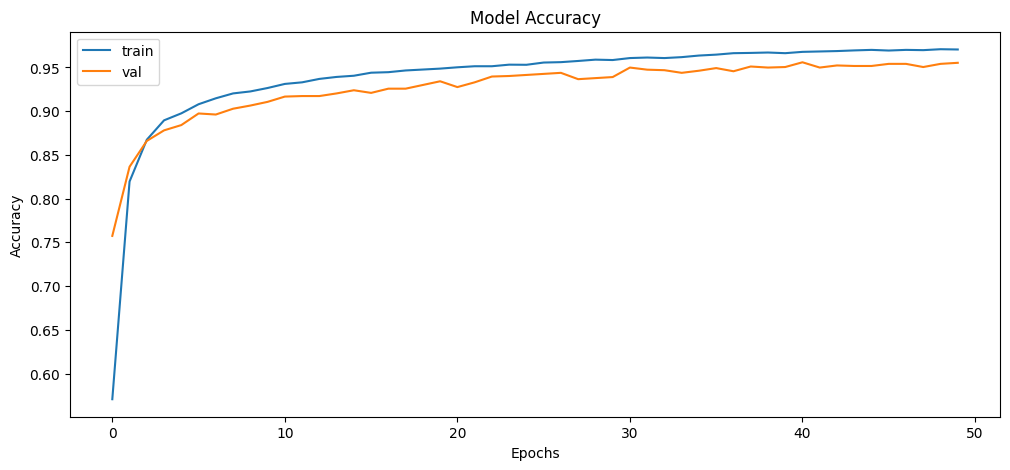

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

In [16]:
scores = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {scores[1] * 100}')
scores

 1/65 ━━━━━━━━━━━━━━━━━━━━ 30:30 29s/step - accuracy: 0.9062 - loss: 0.2777

W0000 00:00:1710345072.810557     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 61s 506ms/step - accuracy: 0.9516 - loss: 0.1465
Test Accuracy: 95.46331763267517


W0000 00:00:1710345105.217834     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.1381908357143402, 0.9546331763267517]

In [17]:
y_pred = model.predict(x_test)

 2/65 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step 

W0000 00:00:1710345149.231938     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step


W0000 00:00:1710345168.763604     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


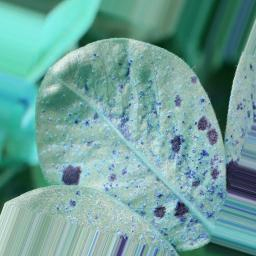

In [18]:
img = array_to_img(x_test[11])
img

In [19]:
print('original label: ', all_labels[np.argmax(y_test[11])])
print('predicted label: ', all_labels[np.argmax(y_pred[11])])
print(y_pred[2])
print((y_test).shape)

original label:  Rust
predicted label:  Rust
[1.5970003e-11 3.7482548e-10 9.9998724e-01 1.3308903e-06 8.9774188e-11
 1.1479345e-05]
(2072, 6)


In [20]:
for i in range(0, len(y_test)):
    print(all_labels[np.argmax(y_test[i])], ' - ', all_labels[np.argmax(y_pred[i])])

Rust  -  Rust
Early Leaf Spot  -  Early Leaf Spot
Rust  -  Rust
Early Rust  -  Early Rust
Early Rust  -  Early Rust
Rust  -  Rust
Late Leaf Spot  -  Late Leaf Spot
Early Rust  -  Early Rust
Early Leaf Spot  -  Healthy Leaf
Late Leaf Spot  -  Late Leaf Spot
Nutritional Deficiency  -  Nutritional Deficiency
Rust  -  Rust
Late Leaf Spot  -  Late Leaf Spot
Early Rust  -  Early Rust
Early Leaf Spot  -  Early Leaf Spot
Healthy Leaf  -  Healthy Leaf
Healthy Leaf  -  Healthy Leaf
Late Leaf Spot  -  Late Leaf Spot
Late Leaf Spot  -  Late Leaf Spot
Healthy Leaf  -  Healthy Leaf
Rust  -  Early Rust
Early Leaf Spot  -  Early Leaf Spot
Early Leaf Spot  -  Early Leaf Spot
Early Leaf Spot  -  Early Leaf Spot
Early Rust  -  Early Rust
Late Leaf Spot  -  Late Leaf Spot
Rust  -  Rust
Rust  -  Rust
Early Leaf Spot  -  Early Leaf Spot
Nutritional Deficiency  -  Healthy Leaf
Late Leaf Spot  -  Late Leaf Spot
Late Leaf Spot  -  Late Leaf Spot
Rust  -  Rust
Healthy Leaf  -  Healthy Leaf
Rust  -  Rust
Early R